<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/Probability_Calibration/01_Probability_Calibration_Model_Not_Ensemble_Not_Fitted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import warnings

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.calibration import (
    CalibratedClassifierCV,
    calibration_curve)

from sklearn.model_selection import (
    train_test_split, GridSearchCV)

from sklearn.metrics import brier_score_loss

from sklearn.tree import DecisionTreeClassifier

The purpose of this exercise is to validate the process of model calibration when the focus is on probabilities. Binary and multiclass classification will be explored. The methods 'CalibratedClassifierCV', 'calibration_curve', and the metric 'brier_score_loss' will be used

# **Settings**
---

In [124]:
random_seed=12345
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")

# **Data**
---

For the different configurations in the calibration process, synthetic data will be generated with different configurations.

In [125]:
def data_generator(**kward):
  X, y = make_classification(
      random_state = random_seed,
      **kward
  )
  return X, y

# **Calibration**
---

## **Model, not ensemble not Fitted**
---
- The model will be a non-'ensemble' model and will not be trained.

**Data**

A synthetic dataset of 800 records will be generated, with 10 features, of which 8 will be informative and 2 will be redundant. It will be a binary classification dataset, with a classification error rate of 8% and a separation of 0.5.

In [126]:
X, y = data_generator(
    **{
      "n_samples":800,
      "n_features":10,
      "n_informative":8,
      "n_redundant":2,
      "n_classes":2,
      "flip_y":0.08,
      "class_sep":0.5
      }
)

**Data Split**

In [127]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=random_seed
)

**Model**

A decision tree is instantiated with basic configurations and without fit.

In [128]:
model_tree = DecisionTreeClassifier(
    max_depth = 5,
    random_state=random_seed
)

The model's probabilities are calibrated using the 'CalibratedClassifierCV' function with 10 'cv' and the 'sigmoid' method.

In [129]:
calibrate_model_tree = CalibratedClassifierCV(
    estimator=model_tree,
    method='sigmoid',
    cv=10,
    ensemble=False,
)
calibrate_model_tree.fit(X_train, y_train)

CalibratedClassifierCV(cv=10, ensemble=False,
                       estimator=DecisionTreeClassifier(max_depth=5,
                                                        random_state=12345))

The test probabilities are obtained.

In [130]:
calibreated_probs_test = calibrate_model_tree.predict_proba(X_test)

The previously configured, uncalibrated model is fitted. Then, probability predictions are made. This is done to compare the model's calibration


In [131]:
model_tree.fit(X_train, y_train)

model_probs_test = model_tree.predict_proba(X_test)

Having the probabilities, a comparison is made between the calibrated model and the fitted model.

It will be assumed that class 1 is the class of interest, however, the process will be validated with both classes

In [132]:
X_test.shape[0]/50

4.0

one class or another, the number of selected 'bins' may be smaller, as those with no probability will collapse. To get a good idea of how many groups can be obtained, a histogram is used to determine how many bins are suitable for grouping the average probabilities.

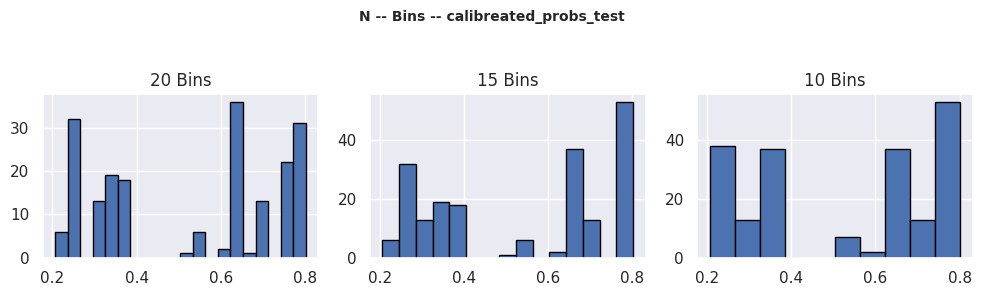

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
ax[0].hist(calibreated_probs_test[:,1], bins=20, edgecolor='black')
ax[0].set_title('20 Bins')

ax[1].hist(calibreated_probs_test[:,1], bins=15, edgecolor='black')
ax[1].set_title('15 Bins')
ax[2].hist(calibreated_probs_test[:,1], bins=10, edgecolor='black')
ax[2].set_title('10 Bins')
fig.tight_layout()
plt.subplots_adjust(top = 0.7)
fig.suptitle('N -- Bins -- calibreated_probs_test', fontsize = 10, fontweight = "bold");
plt.show()

- The number of 'bins' is set to 20, as a more accurate estimation can be obtained visually.

To be consistent with the visualization and comparison, the number 20 will be selected for the remaining functions to obtain a calibration curve.

In [134]:
prob_true_cali_target, prob_pred_cali_target = calibration_curve(y_test, calibreated_probs_test[:,1], n_bins=10)
prob_true_cali_no_target, prob_pred_cali_no_target = calibration_curve(y_test, calibreated_probs_test[:,0], n_bins=20)

prob_true_model_target, prob_pred_model_target = calibration_curve(y_test, model_probs_test[:,1], n_bins=10)
prob_true_model_no_target, prob_pred_model_no_target = calibration_curve(y_test, model_probs_test[:,0], n_bins=20)

In [135]:
brier_score = brier_score_loss(y_test, calibreated_probs_test[:, 1])
brier_score

0.20694873301518107

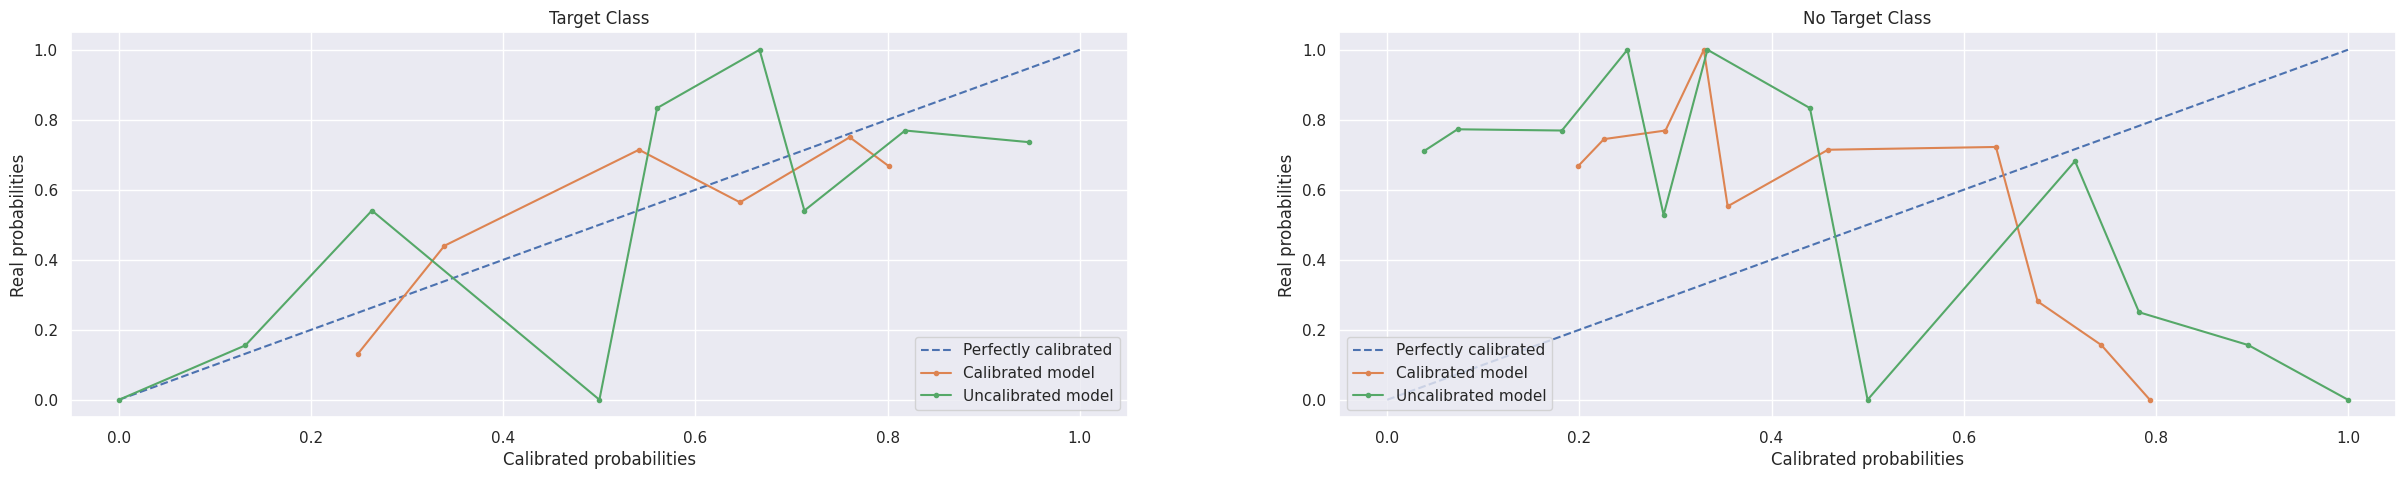

In [136]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 5))
ax[0].plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
ax[0].plot(prob_pred_cali_target, prob_true_cali_target, marker='.', label='Calibrated model')
ax[0].plot(prob_pred_model_target, prob_true_model_target, marker='.', label='Uncalibrated model')
ax[0].set_title("Target Class")
ax[0].legend(loc='lower right')
ax[0].set_xlabel('Calibrated probabilities')
ax[0].set_ylabel('Real probabilities')
ax[1].plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
ax[1].plot(prob_pred_cali_no_target, prob_true_cali_no_target, marker='.', label='Calibrated model')
ax[1].plot(prob_pred_model_no_target, prob_true_model_no_target, marker='.', label='Uncalibrated model')
ax[1].legend(loc='lower left')
ax[1].set_title("No Target Class")
ax[1].set_xlabel('Calibrated probabilities')
ax[1].set_ylabel('Real probabilities')
plt.show()

- The uncalibrated model (green line) is somewhat erratic, tending to significantly overestimate and underestimate some predictions, Some significant cases such as:
 -  For a group of records with a true probability of 54% of being the target class, the model could predict 26%. The model is underestimating the probability
 - For a group of records with a true probability of 0% of being the target class, the model could predict 50%. The model is overestimating the probability
 - For a group of records with a true probability of 83% of being the target class, the model could predict 56%. The model is underestimating the probability
  - For a group of records with a true probability of 100% of being the target class, the model could predict 60%. The model is underestimating the probability

The model whose probabilities are calibrated (orange line) is closer to the diagonal line (perfectly calibrated probabilities), some relevant cases are:
 - For a group of records with a true probability of 71% of being the target class, the model could predict 54%. The model is underestimating the probability

 - For a group of records with a true probability of 66% of being the target class, the model could predict 80%. The model is overestimating the probability
